### Introduction to models

In [1]:
import torch
import pyro

In [2]:
m = 0
s = 1
normal = torch.distributions.Normal(m, s)
x = normal.rsample()
print('sample', x)
print('log prob', normal.log_prob(x))

sample tensor(-1.3357)
log prob tensor(-1.8110)


In [3]:
def weather():
    cloudy = pyro.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

In [4]:
weather()

('sunny', 97.01063537597656)

In [5]:
cloudy_pdf = pyro.distributions.Bernoulli(0.3)

def temp_pdf(is_cloudy):
  m, s = (55.0, 10.0) if is_cloudy else (75.0, 15.0)
  return pyro.distributions.Normal(m, s)

def cloudy_str(is_cloudy):
  return 'cloudy' if is_cloudy else 'sunny'

def weather():
  cloudy = pyro.sample('cloudy', cloudy_pdf)
  is_cloudy = cloudy.item() == 1.0
  temp = pyro.sample('temp', temp_pdf(is_cloudy))
  return is_cloudy, temp.item()

for _ in range(3):
  is_cloudy, temp = weather()
  print((cloudy_str(is_cloudy), temp))

('sunny', 43.183597564697266)
('cloudy', 55.55808639526367)
('sunny', 103.19703674316406)


In [6]:
def ice_cream_pdf(is_cloudy, temp):
  m = 200.0 if not is_cloudy and temp > 80.0 else 50.0
  return pyro.distributions.Normal(m, 10.0)

def ice_cream_sales():
  return pyro.sample('ice_cream', ice_cream_pdf(*weather()))

for _ in range(10):
  print(ice_cream_sales().item())

62.67461013793945
64.92877960205078
67.72350311279297
54.39554214477539
204.452880859375
33.4540901184082
52.21428298950195
54.8080940246582
201.04031372070312
55.73650360107422


In [7]:
def geometric(p, t=None):
  if t is None:
    t = 0
  x = pyro.sample(f'x_{t}', pyro.distributions.Bernoulli(p))
  if x.item() == 1:
    return 0
  else:
    return 1 + geometric(p, t+1)

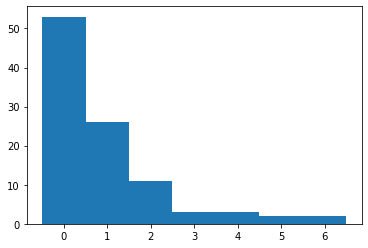

In [28]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

c = Counter(geometric(0.5) for _ in range(100))
labels, vals = zip(*sorted(c.items()))

width = 1
inds = np.arange(len(labels))
plt.bar(inds, vals, width)
plt.xticks(inds, labels)
plt.show()

In [29]:
def normal_product(m, s):
  n = pyro.distributions.Normal(m, s)
  z1 = pyro.sample('z1', n)
  z2 = pyro.sample('z2', n)
  return z1 * z2

def make_normal_normal():
  n = pyro.distributions.Normal(0,1)
  mu_latent = pyro.sample('mu_latent', n)
  return lambda s: normal_product(mu_latent, s)

print(make_normal_normal()(1.0))

tensor(-0.3078)


### Inference using Scale example

In [30]:
import pyro.infer
import pyro.optim
import pyro.distributions as dist

In [31]:
def scale(guess):
  weight = pyro.sample('weight', dist.Normal(guess, 1.0))
  return pyro.sample('measurement', dist.Normal(weight, 0.75))

for _ in range(4):
  print(scale(10))

tensor(11.7514)
tensor(10.8844)
tensor(10.3078)
tensor(9.4212)


In [52]:
cond_scale = pyro.condition(scale, data={'measurement': 9.5})

In [56]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=dist.constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))

a = 9.132761001586914
b = 0.5983076691627502


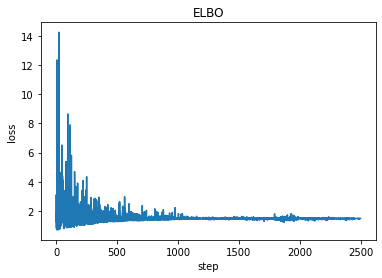

In [57]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model = cond_scale,
                     guide = scale_parametrized_guide,
                     optim = pyro.optim.SGD({'lr': 0.001, 'momentum': 0.1}),
                     loss = pyro.infer.Trace_ELBO())
losses, a, b = [], [] ,[]
num_steps = 2500
for t in range(num_steps):
  losses.append(svi.step(guess))
  a.append(pyro.param('a').item())
  b.append(pyro.param('b').item())

plt.plot(losses)
plt.title('ELBO')
plt.xlabel('step')
plt.ylabel('loss')
print(f'a = {pyro.param("a").item()}')
print(f'b = {pyro.param("b").item()}')

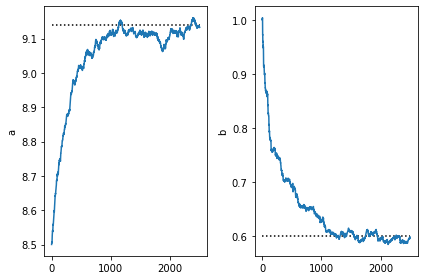

In [59]:
plt.subplot(1,2,1)
plt.plot([0, num_steps], [9.14, 9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.plot([0, num_steps], [0.6, 0.6], 'k:')
plt.plot(b)
plt.ylabel('b')

plt.tight_layout()

### SVI Part 1

In [60]:
def coin_model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli
        # likelihood Bernoulli(f)
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

In [62]:
def coin_guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=dist.constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=dist.constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [105]:
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
# data = []
# for _ in range(6):
#     data.append(torch.tensor(1.0))
# for _ in range(4):
#     data.append(torch.tensor(0.0))

# replaced to try running with subsampling
# note: data needs to be in the form of a torch tensor now
data = torch.zeros(10)
data[0:6] = torch.ones(6) # 6 heads and 4 tails

# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

# setup the inference algorithm
svi = pyro.infer.SVI(coin_model, coin_guide, optimizer, loss=pyro.infer.Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

..................................................

In [106]:
import math

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.538 +- 0.089


### SVI Part 2

In [107]:
# define the hyperparameters that control the beta prior
alpha0 = torch.tensor(10.0)
beta0 = torch.tensor(10.0)

In [108]:
# sequential plate
def coin_model(data):
  f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
  for i in pyro.plate('data_loop', len(data)):
    pyro.sample(f"obs_{i}", dist.Bernoulli(f), obs=data[i])

In [109]:
# vectorized plate
# note: data needs to be in the form of a torch tensor now
data = torch.zeros(10)
data[0:6] = torch.ones(6) # 6 heads and 4 tails

def coin_model(data):
  f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
  # plate gives a conditional independence context
  with pyro.plate('observed_data', size = 10, subsample_size = 5) as ind:
    pyro.sample('obs', dist.Bernoulli(f), obs=data.index_select(0, ind))

### SVI Part 3

In [111]:
# template from SVI Tutorial Part 3

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO

def param_abs_error(name, target):
    return torch.sum(torch.abs(target - pyro.param(name))).item()

class Inference:
  def __init__(self, data, max_steps = 10000):
    self.max_steps = max_steps
    self.data = data
    self.n_data = self.data.size(0)
    # declare parameters
    # declare initial values for guide params

  def model(self):
    # declare the model
    pass
  
  def guide(self):
    # declare the guide
    pass

  def do_inference(self, tol=0.8):
    pyro.clear_param_store()
    optimizer = optim.Adam({'lr': .0005, 'betas': (0.93, 0.999)})
    svi = SVI(self.model, self.guide, optimizer, loss=TraceGraph_ELBO())
    print('Doing inference:')
    
    for k in range(self.max_steps):
      svi.step()
      if k % 100 == 0:
        print('.', end='')
        
      # compute some error using param_abs_error
      
      # stop inference early if error is small
      # if some_error < tol:
      #   break
      
    print(f'\nDid {k} steps of inference.')